In [20]:
%matplotlib inline

In [21]:
import sys
for m in list(sys.modules.keys()):
    if m.startswith("am.") or m in ["config", "data_retrieval", "preprocessing", "model", "classify_feats"]:
        del(sys.modules[m])
import am.main as appr

In [22]:
A = appr.Apprentice()

NameError: name 'draw_img' is not defined

In [ ]:
A("get matching actions")("model")
#A("show action arguments")("load csv")

In [ ]:
for m in list(sys.modules.keys()):
    if m in ["data_retrieval", "preprocessing", "model", "classify_feats"]:
        del(sys.modules[m])

In [ ]:
import config
config.config_A(A)

In [41]:
A("set input shape")(A["nb channels"], *A["dims"])

A("make block from layers")("192conv_1", ["conv3d", "batch norm", "relu", "max pool"], **{"out channels":192, "kernel size":(3,3,2)})
A("make block from layers")("128conv_1", ["conv3d", "batch norm", "relu"], **{"out channels":128, "kernel size":(3,3,2)})
A("make block from layers")("pool_1", ["max pool"], **{"stride":(2,2,1)})
A("make block from layers")("fc_1", ["fc", "relu"], **{"number of units":128})
A("make block from layers")("cls_1", ["fc", "softmax"], **{"number of units":6})

A("build model")(model_name="model1", blocks=["192conv_1", "3x 128conv_1", "pool_1", "fc_1", "cls_1"])

In [43]:
A("validate model")()

Returned array of shape torch.Size([1, 6]) and sum 0.9999998807907104.


In [ ]:
A("set training settings")(**{"batch size": 4, 'epochs': 16, 'steps per epoch': 64, "gpus to use": "all"})

In [ ]:
A("set training dataset")(A["training directory"])

In [ ]:
A("associate ground truth data")(A["training directory"])

In [42]:
print(A["active model"])

=== MODEL1 ===
192conv_1: {CONV (3D, #channels: 192, kernel: (3, 3, 2)) => BN => ReLU => MAX POOL (2)}
128conv_1: {CONV (3D, #channels: 128, kernel: (3, 3, 2)) => BN => ReLU}
128conv_2: {CONV (3D, #channels: 128, kernel: (3, 3, 2)) => BN => ReLU}
128conv_3: {CONV (3D, #channels: 128, kernel: (3, 3, 2)) => BN => ReLU}
pool_1: {MAX POOL ((2, 2, 1))}
fc_1: {FC (#units: 128) => ReLU}
cls_1: {FC (#units: 6) => Softmax}


In [247]:
A("build model")(model_name="model1", blocks=["192conv_1", "3x 128conv_1", "pool_1", "fc_1", "cls_1"])

In [218]:
A("make block from layers")("block1", ["conv3d", "batch norm", "relu"], **{"kernel size":(3,3,2)})

In [219]:
A("build model")(model_name="model1")

In [220]:
A("set input shape")((1,30,30,30))

In [222]:
A("validate model")()

Returned array of shape torch.Size([1, 128, 28, 28, 29]) and sum tensor(0.5687, grad_fn=<SumBackward0>).


In [191]:
print(A["active model"])

=== MODEL1 ===
block1: {CONV (3D, #channels: 128, kernel: (3, 3, 2)) => BN => ReLU}


In [195]:
A["active layers"][0]["padding"]

In [79]:
A("show model")()

In [62]:
[m for m in sys.modules if m.startswith("cnn_runner")]

['dr_methods', 'cnn_builder', 'cnn_runner']

In [12]:
import copy
import glob
import importlib
import itertools
import math
import operator
import os
import random
import time
from os.path import *
import psutil
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
%matplotlib inline

## DDPG

In [4]:
import ddpg.env as denv
import ddpg.main as qmain
import ddpg.learning_nets as ln
import ddpg.task_nets as tn
importlib.reload(cbuild)
C = config.Config()

In [2]:
def memory():
    pid = os.getpid()
    py = psutil.Process(pid)
    gigs = py.memory_info()[0]/2.**30
    print('Memory use:', gigs)
    return gigs

In [ ]:
dqn_generator = cbuild._train_gen_ddpg()

In [4]:
Q = qmain.CRSNet(.75)

In [ ]:
replay_conf = {'size': 10000,
                'learn_start': 100,
                'partition_num': 100,
                'total_step': 10000,
                'batch_size': 4} #4
BATCH_SIZE = replay_conf["batch_size"]

Q.load_models(replay_conf)

In [6]:
Q.env.train_model.load_weights(join(C.model_dir, "train.h5"))
Q.env.pred_model.load_weights(join(C.model_dir, "pred.h5"))

In [7]:
action = [.5]*3+[1]*3+[.5,.9,.1,0]

In [8]:
img, true_seg, true_cls = next(dqn_generator)

In [ ]:
center = action[:3] * np.array(img.shape[:3])
dx = action[3:6] * np.array(img.shape[:3]) / 2
#phase_shift = action[6:9] * 10

bbox = [[round(center[i]-dx[i]),
    round(center[i]+dx[i])] for i in range(3)]

#wide_bbox = np.zeros((3,2))
for i in range(3):
    bbox[i][1] = max(self.min_x+1, min(self.img.shape[i] - 1, bbox[i][1]))
    bbox[i][0] = max(1, min(bbox[i][1] - self.min_x, bbox[i][0]))

In [ ]:
sl = [slice(bbox[i], bbox[i+1]) for i in [0,2,4]]

In [ ]:
cropI = tr.rescale_img(img[sl], C.dims)
crop_pred_seg, crop_pred_cls = self.pred_model.predict(np.expand_dims(cropI, 0))

In [ ]:
Q.env.pred_model.predict(np.expand_dims(cropI, 0))

In [ ]:
importlib.reload(qmain)
Q = qmain.CRSNet(.75)
Q.train(dqn_generator, verbose=True)

In [5]:
Q.save_models()

In [4]:
os.listdir(C.model_dir)

['actor.h5', 'actor_T.h5', 'critic.h5', 'critic_T.h5', 'pred.h5', 'train.h5']

In [6]:
for fn in glob.glob(join(C.model_dir,"*"))[:4]:
    os.remove(fn)

In [5]:
os.remove(join(C.model_dir, "replay_buffer.bin"))
os.remove(join(C.model_dir, "unet_buffer.bin"))

In [5]:
shutil.rmtree(C.model_dir)

In [6]:
os.makedirs(C.model_dir)

In [24]:
cropI = np.random.normal(size=(1,*C.dims,3))

crop_true_seg = np.random.normal(size=(1,*C.dims,3))
true_cls = np.random.uniform(size=(1,3))

y_true = np.random.normal(size=(1,*C.dims,3))
y_pred = np.random.normal(size=(1,*C.dims,4))

loss_layer = train_model.layers[-1]

In [ ]:
importlib.reload(tn)
for _ in range(10):
    log_vars = [K.get_value(x)[0] for x in train_model.layers[-1].log_vars]
    loss = np.sum(np.exp(-log_vars[0]) * K.get_value(tn.hetero_cls_loss(y_true, y_pred)) + log_vars[0], -1)
    print(np.mean(loss))
    memory();

In [30]:
A = prediction_model.predict(cropI)

In [ ]:
for _ in range(10):
    train_model.train_on_batch([cropI, crop_true_seg, true_cls], None)
    A=prediction_model.predict(cropI);
    print(A[1])
    memory();

In [ ]:
importlib.reload(qmain)
Q = qmain.CRSNet(1.)

replay_conf = {'size': 10000,
        'learn_start': 100,
        'partition_num': 100,
        'total_step': 10000,
        'batch_size': 4}
BATCH_SIZE = replay_conf["batch_size"]

Q.load_models(replay_conf)

In [ ]:
Q.critic.model.summary()

In [ ]:
Q.actor.model.summary()

In [ ]:
Q.env.pred_model.summary()

In [8]:
importlib.reload(qmain)
#Q = qmain.CRSNet(.5)
#img, true_seg, true_cls = next(dqn_generator)
liver_seg, tumor_seg, seg_var, cls = Q.run(img)

....................................................................................................100 steps


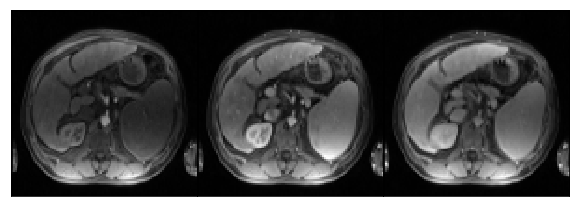

In [9]:
vis.draw_slices(img)

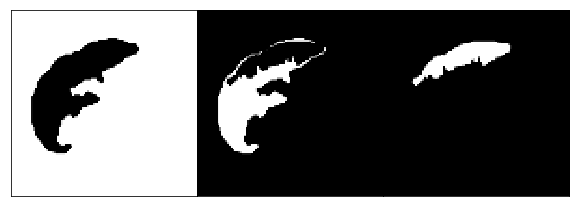

In [10]:
vis.draw_slices(true_seg)

In [18]:
tumor_seg.max()

0.3468440454853562

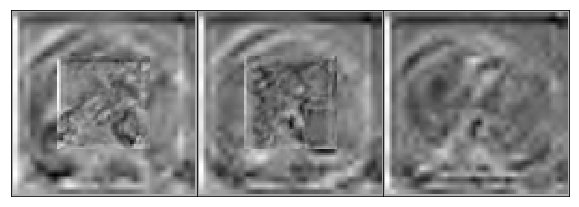

In [16]:
vis.draw_slices(liver_seg, normalize=[0,.05])

In [ ]:
hist = M.fit_generator(gen, steps_per_epoch=2, epochs=2)

prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1
hist = trainable_model.fit([X, Y1, Y2], nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)

[np.exp(K.get_value(log_var[0]))**0.5 for log_var in trainable_model.layers[-1].log_vars]

## Classifier

In [4]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()
T.get_best_hyperparams(C.dataset)
R = crun.CNNRunner(C,T)
#non_hcc_Z = np.array(['E106405787_0','E106329048_0','E106158268_0','E106120112_0','E105906532_0','E105799828_0','E105344790_0','E105333398_0','E105326292_0','E105310461_0','E105160323_0','E105124678_0','E105110150_0','E104082888_0','E103678771_0','E103314435_0','E103306623_0','E103020139_1','E102929168_0','E102634440_0','E102424706_0','E102256903_0','E102088195_1','E102027289_0','E101523098_3','E101449797_0','E101442376_0','E101396972_0','E101290891_0','E101158768_1'])
#hcc_Z = np.array(list(set(C.Z_reader).difference(non_hcc_Z)))

In [5]:
R.run_fixed_hyperparams(max_runs=10, model_name='std_', verbose=True) #Z_test=C.Z_reader, model_name='fixZ_std_',

Epoch 1/350
256/256 [==============================] - 28s 111ms/step - loss: 1.6242 - acc: 0.4259 - val_loss: 1.2013 - val_acc: 0.5000
Epoch 2/350
256/256 [==============================] - 20s 78ms/step - loss: 1.2090 - acc: 0.5807 - val_loss: 1.0598 - val_acc: 0.5667
Epoch 3/350
256/256 [==============================] - 20s 79ms/step - loss: 1.0826 - acc: 0.6370 - val_loss: 0.9468 - val_acc: 0.6667
Epoch 4/350
256/256 [==============================] - 20s 79ms/step - loss: 1.0314 - acc: 0.6584 - val_loss: 0.7907 - val_acc: 0.6333
Epoch 5/350
256/256 [==============================] - 20s 79ms/step - loss: 0.9662 - acc: 0.6790 - val_loss: 0.7844 - val_acc: 0.7667
Epoch 6/350
256/256 [==============================] - 20s 79ms/step - loss: 0.8690 - acc: 0.7181 - val_loss: 0.7307 - val_acc: 0.7000
Epoch 7/350
256/256 [==============================] - 20s 80ms/step - loss: 0.8964 - acc: 0.7116 - val_loss: 0.7469 - val_acc: 0.7333
Epoch 8/350
256/256 [==============================] -

In [ ]:
R.run_fixed_hyperparams(max_runs=10, Z_test=C.Z_reader, model_name='fixZ_std_', verbose=True)

In [3]:
X_test, Y_test, train_gen, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4)

In [68]:
X_test, Y_test, train_gen, num_samples, train_orig, Z = cbuild.get_cnn_data(n=R.T.n,
					Z_test_fixed=R.Z_test)

if R.C.aug_pred:
    x = np.empty((R.C.aug_factor, *R.C.dims, R.C.nb_channels))
    Y_pred = []
    for z in R.Z_test:
        x = np.stack([np.load(fn) for fn in glob.glob(join(C.aug_dir,"*")) if basename(fn).startswith(z)], 0)
        y = R.pred_model.predict(x)
        Y_pred.append(np.median(y, 0))
    Y_pred = np.array(Y_pred)
elif R.T.mc_sampling:
    Y_pred = []
    for ix in range(len(R.Z_test)):
        x = np.tile(X_test[ix], (256, 1,1,1,1))
        y = R.pred_model.predict(x)
        Y_pred.append(np.median(y, 0))
    Y_pred = np.array(Y_pred)
else:
    Y_pred = R.pred_model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])
miscls_test = list(R.Z_test[~np.equal(y_pred, y_true)])

1-len(miscls_test)/60

11

In [ ]:
R.pred_model.summary()

importlib.reload(crun)
R = crun.CNNRunner(C,T)
if C.ensemble_num > 0:
    R.run_ensemble(max_runs=5)
else:
    R.run_fixed_hyperparams(max_runs=5)

#R.C.clinical_inputs = 0
#R.run_fixed_hyperparams(max_runs=5)

In [5]:
X_test, Y_test, train_gen, num_samples, train_orig, Z = cbuild.get_cnn_data(n=T.n, Z_test_fixed=C.Z_reader)

In [ ]:
np.random.shuffle(hcc_Z)
np.random.shuffle(non_hcc_Z)
for ix in range(len(hcc_Z)//C.test_num):
    Z = np.concatenate((hcc_Z[ix*C.test_num : (ix+1)*C.test_num], non_hcc_Z[ix*C.test_num : (ix+1)*C.test_num]))
    R.run_fixed_hyperparams(max_runs=1, Z_test=Z, model_name='fixZ_1run_', verbose=True)
R.run_fixed_hyperparams(max_runs=10, model_name='radpath_')

if C.ensemble_num > 0:
    R.run_ensemble(max_runs=5, Z_test=Z_reader, model_name='fixZ_')
else:
    R.run_fixed_hyperparams(max_runs=3, Z_test=radpath_reader, model_name='fixZ_std_')
"""R.C.clinical_inputs = 0
R.run_fixed_hyperparams(max_runs=3, Z_test=Z_reader, model_name='fixZ_noclinical_')""";

In [ ]:
T.padding = ['same', 'same']
T.pool_sizes = [(2,2,2),(2,2,2)]
T.f = [64,64,64,64,64,64,64]
T.skip_con = True
T.epochs = 20

In [ ]:
drm.dcm2npy_batch(acc_nums=["E100113043"])
#vm.reset_accnum('E105464882')

In [ ]:
vm.plot_check(2, "E102088195");

In [ ]:
vm.xref_dirs_with_excel()

In [12]:
M = keras.models.load_model(r"D:\Radpath\models_old\models_169.hdf5")

In [6]:
A = np.zeros((1,24,24,12,3))

In [ ]:
t=time.time()
T = []
for ix in range(1000):
    if ix % 10 == 0:
        T.append(time.time()-t)
        t=time.time()
    M.predict(A)
print(np.mean(T))

In [ ]:
T.mc_sampling = True
pred_model, train_model = cbuild.build_cnn_hyperparams(T)
pred_model.layers[1].set_weights(M.layers[1].get_weights())

In [14]:
df = pd.read_csv(C.run_stats_path)

In [ ]:
importlib.reload(hf)
hf.str_to_list(df.loc[df['model_num'] == 397, 'z_test'].values[0])

In [19]:
Z_test = hf.str_to_list(df.loc[df['model_num'] == 397, 'z_test'].values[0])

In [77]:
importlib.reload(cbuild)
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=10, Z_test_fixed=Z0)

In [33]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

In [21]:
importlib.reload(cbuild)
if C.aleatoric:
    pred_model, train_model = cbuild.build_cnn_hyperparams(T)
    pred_model.layers[1].summary(line_length=120)
else:
    model = cbuild.build_cnn_hyperparams(T)
    model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_59 (InputLayer)                  (None, 24, 24, 12, 3)      0                                                     
________________________________________________________________________________________________________________________
lambda_175 (Lambda)                    (None, 24, 24, 12, 1)      0             input_59[0][0]                          
________________________________________________________________________________________________________________________
lambda_176 (Lambda)                    (None, 24, 24, 12, 1)      0             input_59[0][0]                          
________________________________________________________________________________________________________________________
lambda_177 (Lambda)             

In [ ]:
importlib.reload(cbuild)
#Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=T.n, Z_test_fixed=Z0)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig
if C.aleatoric:
    hist = train_model.fit_generator(train_generator, T.steps_per_epoch, epochs=T.epochs)
else:
    hist = model.fit_generator(train_generator, T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [27]:
Y_pred = model.predict(X_train_orig)

In [ ]:
Y_train_orig

In [ ]:
Y_pred

In [38]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

In [36]:
for fn in glob.glob(r"D:\Radpath\imgs\rough_crops\*\*.npy"):
    os.rename(fn, join(dirname(dirname(fn)), basename(fn)))

In [7]:
model.save(join(C.model_dir, "classifier_1.h5"))

In [45]:
model = keras.models.load_model(join(C.model_dir, "models_305.hdf5"))

In [ ]:
model.predict(X_train_orig[20:23])

In [ ]:
Y_train_orig[:20]

In [ ]:
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [ ]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

print(accuracy_score(y_true, y_pred))
#y_true_simp, y_pred_simp, _ = cnna.merge_classes(y_true, y_pred)
#print(accuracy_score(y_true_simp, y_pred_simp))